## 1. Setup configuraiton

In [74]:
import pandas as pd
from itertools import product
import os
from glob import glob
import warnings ; warnings.filterwarnings('ignore')
import gc ; gc.enable()
import joblib

import numpy as np

import torch
import pytorch_lightning as pl

from matplotlib import pyplot as plt
import matplotlib as MP
import seaborn as sbn


## 2. Sizes of each fold

In [75]:
# Function to load indices for all folds
def load_all_fold_indices(base_path, num_folds):
    all_fold_indices = {}
    for fold in range(1, num_folds + 1):
        indices_path = os.path.join(base_path, f'fold_{fold}', 'indices.joblib')
        indices = joblib.load(indices_path)
        all_fold_indices[fold] = indices
    return all_fold_indices

base_path = 'ckpt/test_Feature_netherlands_8' #Please use your checkpoints path
num_folds = 5
all_fold_indices = load_all_fold_indices(base_path, num_folds)

# Display the loaded indices for verification
for fold, indices in all_fold_indices.items():
    print(f"Fold {fold}:")
    print(f"  Training Indices: {len(indices['train_index'])} samples")
    print(f"  Validation Indices: {len(indices['val_index'])} samples")


Fold 1:
  Training Indices: 17532 samples
  Validation Indices: 3506 samples
Fold 2:
  Training Indices: 17532 samples
  Validation Indices: 3506 samples
Fold 3:
  Training Indices: 17532 samples
  Validation Indices: 3506 samples
Fold 4:
  Training Indices: 17532 samples
  Validation Indices: 3506 samples
Fold 5:
  Training Indices: 17532 samples
  Validation Indices: 3506 samples


## 3. Validation Data Ranges

In [76]:
# Generate the list of timestamps
timestamps = pd.date_range(start='2020-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H')

def get_date_range_for_indices(indices, timestamps):
    start_date = timestamps[indices[0]]
    end_date = timestamps[indices[-1]]
    return start_date, end_date

validation_date_ranges = []

for fold, indices in all_fold_indices.items():
    val_start_date, val_end_date = get_date_range_for_indices(indices['val_index'], timestamps)
    validation_date_ranges.append((val_start_date, val_end_date))
    print(f"Fold {fold} Validation Date Range: {val_start_date} to {val_end_date}")

print("Validation Date Ranges for each fold:", validation_date_ranges)


Fold 1 Validation Date Range: 2021-12-31 12:00:00 to 2022-05-26 13:00:00
Fold 2 Validation Date Range: 2022-05-26 14:00:00 to 2022-10-19 15:00:00
Fold 3 Validation Date Range: 2022-10-19 16:00:00 to 2023-03-14 17:00:00
Fold 4 Validation Date Range: 2023-03-14 18:00:00 to 2023-08-07 19:00:00
Fold 5 Validation Date Range: 2023-08-07 20:00:00 to 2023-12-31 21:00:00
Validation Date Ranges for each fold: [(Timestamp('2021-12-31 12:00:00'), Timestamp('2022-05-26 13:00:00')), (Timestamp('2022-05-26 14:00:00'), Timestamp('2022-10-19 15:00:00')), (Timestamp('2022-10-19 16:00:00'), Timestamp('2023-03-14 17:00:00')), (Timestamp('2023-03-14 18:00:00'), Timestamp('2023-08-07 19:00:00')), (Timestamp('2023-08-07 20:00:00'), Timestamp('2023-12-31 21:00:00'))]


In [77]:
def get_sample_numb(input_date):
    return timestamps.get_loc(input_date)

def determine_fold_and_sample(input_date, validation_date_ranges, timestamps):
    sample_numb = get_sample_numb(input_date)
    for fold, (start_date, end_date) in enumerate(validation_date_ranges, start=1):
        if start_date <= pd.Timestamp(input_date) <= end_date:
            fold_sample_numb = sample_numb - get_sample_numb(start_date)
            return fold, fold_sample_numb
    return None, None

# Example usage
input_date = '2023-07-17 09:00:00'  # Replace this with the desired date and time from validation data range.
fold, sample_numb = determine_fold_and_sample(input_date, validation_date_ranges, timestamps)
print(f"Sample number for {input_date}: {sample_numb} (Fold: {fold})")


Sample number for 2023-07-17 09:00:00: 2991 (Fold: 4)


#### Please use your checkpoints path

In [78]:
# Load necessary data for the specific fold
log = joblib.load(os.path.join(base_path, f'fold_{fold}', 'log.joblib'))
data = joblib.load(os.path.join(base_path, f'fold_{fold}', 'data_samples.joblib'))
ckpt = torch.load(glob(os.path.join(base_path, f'fold_{fold}', 'epoch*'))[0])
config = log['config']
scaler = log['scaler']
device = torch.device(f'cuda:{config.gpu_numb[0]}')

In [79]:
data.keys()

dict_keys(['train', 'valid'])

In [80]:
from src.models.natm import pl_natm
from src.data_prepare import pl_DataModule
from sklearn.preprocessing import StandardScaler

### please change to the natms type what you learned before
### config.natm_type = 'Feature' or others in ['Independent','Time']

model = pl_natm(config)
model.to(device)
model.eval()
model.load_state_dict(ckpt['state_dict'])


<All keys matched successfully>

In [81]:
# Split the data into validation sets
valid_x, valid_y = data['valid'][:,:-1], data['valid'][:,-1]

#### You can visualized the other sample to change the number of 'sample_numb'

In [82]:
x = valid_x[sample_numb:sample_numb+1]
y = valid_y[sample_numb:sample_numb+1]

with torch.no_grad():
    torch_x = torch.tensor(
            x, device = device
    ).float()
    basis_weight = model.model.compute_weight(torch_x)
    series_weights = (basis_weight[0] * model.model.output_linear.weight.transpose(1,0)).cpu().numpy()
    logits, _ = model(torch_x)
    logits = logits.cpu().numpy()

#### In figure real value $X$ and $Y$ marked with circle, and predicted $\hat{Y}$ marked with x.

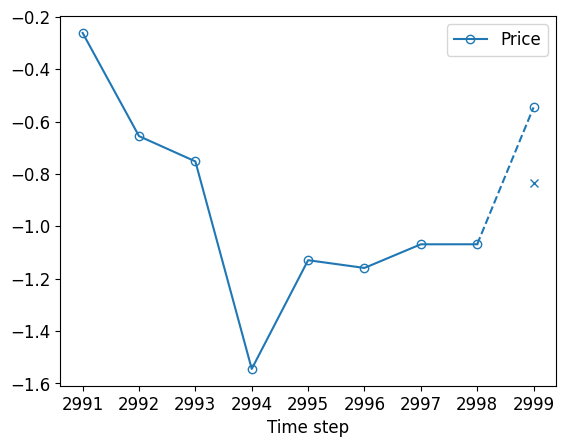

In [83]:
fig, ax = plt.subplots(1, 1)

st = sample_numb
ed = sample_numb + len(x[0])

# Ensure 'Price' is correctly identified
price_index = list(log['columns']).index('Price')

# Plot the "Price" series from x[0]
ax.plot(range(st, ed), x[0][:, price_index], marker='o', markerfacecolor='none')
ax.set_xlabel('Time step')

# Plot the "Price" series from the concatenated array
v = np.concatenate([x[0, -1:, price_index], y[:, price_index]]).flatten()
ax.plot(range(ed - 1, ed + 1), v, '--', color=list(MP.colors.TABLEAU_COLORS)[price_index])
ax.plot(ed, v[1], marker='o', markerfacecolor='none', color=list(MP.colors.TABLEAU_COLORS)[price_index])
ax.plot(ed, logits[price_index], marker='x', markerfacecolor='none', color=list(MP.colors.TABLEAU_COLORS)[price_index])

ax.set_rasterized(True)
ax.legend(['Price'])

plt.show()


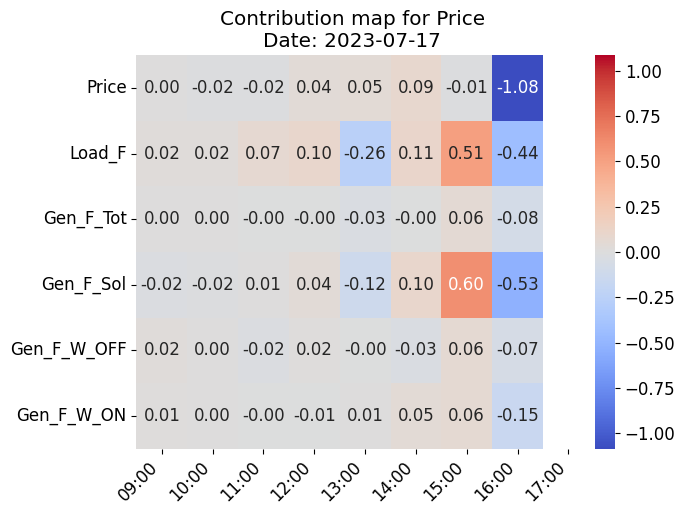

In [84]:
# Correctly extract the corresponding timestamps for the validation data
val_indices = all_fold_indices[fold]['val_index']
ts_range = timestamps[val_indices[sample_numb]:val_indices[sample_numb] + len(x[0]) + 1]

# Update the plot formatting
plt.rcParams['font.size'] = 12

for n, series_name in enumerate(log['columns']):
    invert_sw = series_weights[:, n].reshape(-1, config.input_feature)

    max_v = invert_sw.max()
    min_v = invert_sw.min()
    thr_v = max_v if max_v > np.abs(min_v) else np.abs(min_v)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    sbn.heatmap(
        invert_sw.transpose(),
        vmin=-thr_v,
        vmax=thr_v,
        xticklabels=[t.strftime('%H:%M') for t in ts_range],
        yticklabels=log['columns'],
        cmap='coolwarm',
        ax=ax,
        annot=True,
        fmt='.2f'
    )

    ax.set_title(f'Contribution map for {series_name}\nDate: {pd.Timestamp(input_date).strftime("%Y-%m-%d")}')
    fig.tight_layout(pad=1.01)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.show()

    break